Martin Acob
<br/>
Professor Fitzgerald
<br/>
Stat 196K
<br/>
14 May 2021

<h1/><center/> Final Project: Clustering Covid Data

<h3/> Introduction

<font size="3"/> In the year 2020, both the COVID-19 and president election was happening. Between the Republican candidate ( President Trump), Democratic candidate (President Biden), and their followers had differing opinions on wearing masks and the covid vaccine. Those who were generally against wearing masks and the vaccine were supporters of President Trump. During this pandemic plenty of data is collected and can do many interesting analysis on all of this data. For this final project I want to answer the question, "Are counties that are more democratic or more republican more likely to wear a mask and receive the vaccine?" This idea was first presented by Professor Fitzgerald and I wanted to follow up on it.

<h3> Method

<font size="3"/>To answer this question, I decided to use the concepts learned from class on the database (AWS Athena), Julia programming, dimension reduction(PCA), and clustering(Kmeans). Through AWS Athena, I wanted to add on to the existing covid database created created by Facebook surveys with number of votes per candidate, income, and population in a county level. AWS Glue will also be used for its crawling features to make faster queries. To help determine whether counties accept the covid vaccine and wearing masks, two signals from the Facebook survey will be used. The 'smoothed_waccept_covid_vaccine' and 'smoothed_wwearing_mask'. Then PCA will be applied the the numerical data and will be applied to KMeans with 2 clusters. 

<h3> Data

County level election Result: https://github.com/tonmcg/US_County_Level_Election_Results_08-20/blob/master/2020_US_County_Level_Presidential_Results.csv

Income and Population: https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/

In [2]:
import Clustering

using MultivariateStats
using Plots
using CSV
using DataFrames

<h3> SQL Query

In [ ]:
SELECT state_name, county_fips, county_name, val_acc_vacc, val_wearing_mask, votes_gop, votes_dem, total_votes, per_gop, 
    per_dem, population, income
FROM 
(SELECT state_name, county_fips, county_name, value AS val_acc_vacc, votes_gop, votes_dem, total_votes, per_gop, per_dem, 
    pop_estimate_2019 AS population, median_household_income_2019 AS income
FROM covid, final_data, income_data, pop_data
WHERE covid.geo_type= 'county'
AND signal = 'smoothed_waccept_covid_vaccine'
AND CAST(covid.geo_value AS int) = CAST(final_data.county_fips AS int)
AND CAST(covid.geo_value AS int) = CAST(income_data.fips_txt AS int)
AND CAST(covid.geo_value AS int) = CAST(pop_data.FIPStxt AS int)
AND time_value = 20210101) AS acc_vacc(state_name, county_fips, county_name, val_acc_vacc, votes_gop, votes_dem, 
    total_votes, per_gop, per_dem, population, income)
JOIN
(SELECT geo_value, value AS val_wearing_mask
FROM covid
WHERE geo_type = 'county' 
AND signal = 'smoothed_wwearing_mask'
AND time_value = 20210101) AS wear_mask(geo_value, val_wearing_mask)
ON CAST(acc_vacc.county_fips AS int) = CAST(wear_mask.geo_value AS int)

<font size="3"/> Csv file created from the query.

In [3]:
df = DataFrame(CSV.File("final_data.csv"))
size(df)

(594, 12)

In [242]:
size(unique(df.state_name))

(50,)

<font size="3"/> Biggest percentage of Republican candidate vote by county.

In [249]:
df[findmax(df.per_gop)[2],1:6]

,state_name,county_fips,county_name,val_acc_vacc,val_wearing_mask,votes_gop
,String,Int64,String,Float64,Float64,Int64
382,Louisiana,22063,Livingston Parish,51.3556,73.0268,54877


In [250]:
df[findmax(df.per_gop)[2],7:end]

,votes_dem,total_votes,per_gop,per_dem,population,income
,Int64,Int64,Float64,Float64,Int64,Int64
382,9249,65230,0.841285,0.141791,140789,63852


<font size="3"/> Biggest percentage of Democratic candidate vote by county.

In [251]:
df[findmax(df.per_dem)[2],1:6]

,state_name,county_fips,county_name,val_acc_vacc,val_wearing_mask
,String,Int64,String,Float64,Float64
228,District of Columbia,11001,District of Columbia,82.9401,97.0779


In [236]:
df[findmax(df.per_dem)[2],7:end]

,votes_dem,total_votes,per_gop,per_dem,population,income
,Int64,Int64,Float64,Float64,Int64,Int64
228,317323,344356,0.0539732,0.921497,705749,90395


<font size="3"> Creating new dataframe with only numerical data for PCA.

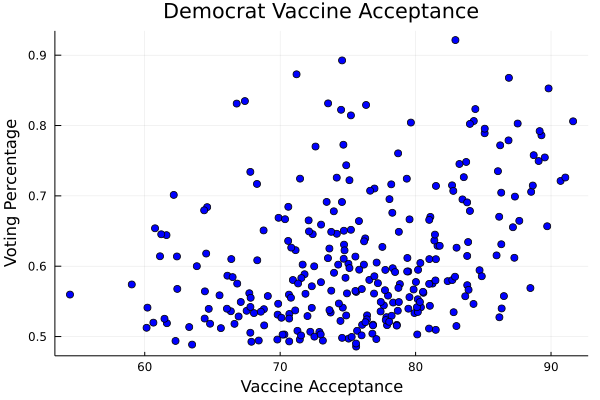

In [17]:
dem = df[df.per_dem.>df.per_gop,:]
scatter(dem.val_acc_vacc,dem.per_dem, color = "blue", title= "Democrat Vaccine Acceptance", xlabel= "Vaccine Acceptance", ylabel="Voting Percentage", legend=false)

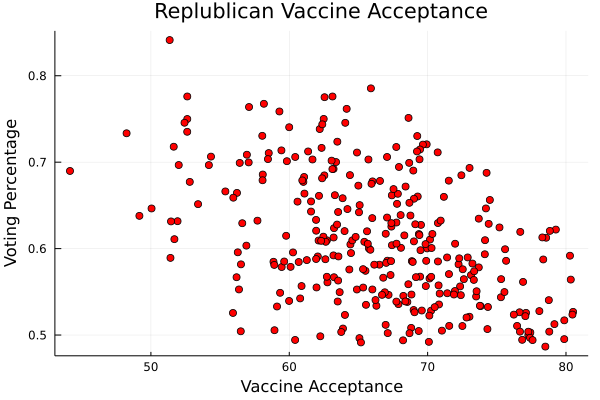

In [15]:
gop = df[df.per_dem.<df.per_gop,:]
scatter(gop.val_acc_vacc,gop.per_gop, color= "red", title= "Replublican Vaccine Acceptance", xlabel= "Vaccine Acceptance", ylabel="Voting Percentage", legend=false)

<font size="3"> Creating new dataframe with only numerical data for PCA.

In [221]:
names(df)

12-element Vector{String}:
 "state_name"
 "county_fips"
 "county_name"
 "val_acc_vacc"
 "val_wearing_mask"
 "votes_gop"
 "votes_dem"
 "total_votes"
 "per_gop"
 "per_dem"
 "population"
 "income"

In [224]:
num_df = select(df, Not([:state_name, :county_fips, :county_name]))
names(num_df)

9-element Vector{String}:
 "val_acc_vacc"
 "val_wearing_mask"
 "votes_gop"
 "votes_dem"
 "total_votes"
 "per_gop"
 "per_dem"
 "population"
 "income"

<h3/> PCA

In [225]:
mtx_df = Matrix(num_df)
tp_mtx = transpose(mtx_df)
pca = fit(PCA, tp_mtx, maxoutdim = 1)

PCA(indim = 9, outdim = 1, principalratio = 0.9909325926101895)

<font size="3"/> When the data is projected to 1 dimension it is representative 99% of the variation in the data.
<br/>

<br/>
<font size="3"/> Taking a look at the top loadings in the PCA. These are some of the most populated states, so the counties from these states would be significant.

In [227]:
proj = abs.(projection(pca)[:,1])
sorted_proj = sortperm(proj, rev = true)
pca_loadings = df[sorted_proj,:]

,state_name,county_fips,county_name,val_acc_vacc,val_wearing_mask,votes_gop
,String,Int64,String,Float64,Float64,Int64
1,Georgia,13115,Floyd County,68.669,88.2842,28906
2,Colorado,8069,Larimer County,80.5756,95.4249,91489
3,California,6065,Riverside County,74.8758,96.1688,448702
4,California,6041,Marin County,84.4113,96.869,24612
5,Illinois,17143,Peoria County,61.6361,92.3582,38252
6,Arizona,4013,Maricopa County,70.3126,92.1158,995665
7,California,6039,Madera County,68.8322,92.9932,29378
8,Florida,12117,Seminole County,71.2766,90.5598,125241
9,Delaware,10001,Kent County,65.6222,96.5662,41009


<h3/> KMeans Clustering

In [210]:
nclusters = 2

k2 = Clustering.kmeans(tp_mtx, nclusters)

Clustering.KmeansResult{Matrix{Float64}, Float64, Int64}([70.65745580017517 75.9726345304348; 91.19960543555167 95.63957296086956; … ; 335178.00350262696 2.890012434782609e6; 67226.71278458844 75704.34782608696], [2, 1, 1, 2, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [3.6213596229850273e12, 5.104629508446277e10, 1.1966828408251678e10, 3.147452784448242e11, 5.399537838705872e9, 3.352334183123297e10, 3.181732232746765e10, 8.0306904070904e10, 3.482289354649176e10, 5.117109327059152e10  …  3.010319277508499e10, 4.533762856591608e10, 2.2217971583720764e10, 1.0731862746749878e9, 5.704179727440933e10, 6.7478046112139755e10, 2.3233849149206177e10, 1.123837210548294e10, 1.5042704411050415e10, 3.953026323374579e10], [571, 23], [571, 23], 1.64975166727693e14, 13, true)

In [211]:
k2.counts

2-element Vector{Int64}:
 571
  23

<font size="3"> The first cluster has about 96% of the counties and the second cluster has about 4% of the counties.

<br/>
<font size="3"/> Looking into the centroids of the 2 clusters.

In [212]:
"""
    Find the indices of the data points that are closest to the centroids defined by the kmeans clustering.
"""
function close_centroids(knn_model)
    groups = knn_model.assignments
    k = length(unique(groups))
    n = length(groups)
    result = fill(0, k)
    for ki in 1:k
        cost_i = fill(Inf, n)
        group_i = ki .== groups
        cost_i[group_i] = knn_model.costs[group_i]
        result[ki] = argmin(cost_i)
    end
    result
end
cc = close_centroids(k2)

2-element Vector{Int64}:
 299
 268

<font size="4"/> Centroid 1

In [254]:
df[cc[1],1:6]

,state_name,county_fips,county_name,val_acc_vacc,val_wearing_mask,votes_gop
,String,Int64,String,Float64,Float64,Int64
299,Oregon,41047,Marion County,63.4975,89.981,79002


In [255]:
df[cc[1],7:end]

,votes_dem,total_votes,per_gop,per_dem,population,income
,Int64,Int64,Float64,Float64,Int64,Int64
299,80872,165534,0.477255,0.488552,347818,64058


<font size="4"/> Centroid 2

In [252]:
df[cc[2],1:6]

,state_name,county_fips,county_name,val_acc_vacc,val_wearing_mask,votes_gop
,String,Int64,String,Float64,Float64,Int64
268,Florida,12086,Miami-Dade County,73.7255,95.869,532833


In [253]:
df[cc[2],7:end]

,votes_dem,total_votes,per_gop,per_dem,population,income
,Int64,Int64,Float64,Float64,Int64,Int64
268,617864,1156816,0.460603,0.534107,2716940,54991


<br/>
<font size="3"/> Splitting the dataframe into their respective clusters.

In [256]:
sorted_cls = sortperm(k2.assignments)
c1_idc = sorted_cls[1:k2.counts[1]]
c2_idc = sorted_cls[(k2.counts[1]+1):end]

c1 = df[c1_idc, :]
c2 = df[c2_idc, :]
size(c1)

(571, 12)

In [257]:
size(c2)

(23, 12)

<font size="3"/> Examples of counties in cluster 1.

<font size="2"/> Example 1

In [263]:
c1[420, 1:6]

,state_name,county_fips,county_name,val_acc_vacc,val_wearing_mask,votes_gop
,String,Int64,String,Float64,Float64,Int64
420,New York,36109,Tompkins County,86.0796,97.6017,11096


In [262]:
c1[420, 7:end]

,votes_dem,total_votes,per_gop,per_dem,population,income
,Int64,Int64,Float64,Float64,Int64,Int64
420,33619,45735,0.242615,0.735083,102180,59176


<font size="2"/> Example 2

In [267]:
c1[87, 1:6]

,state_name,county_fips,county_name,val_acc_vacc,val_wearing_mask,votes_gop
,String,Int64,String,Float64,Float64,Int64
87,Virginia,51700,Newport News city,60.7605,95.7545,26377


In [268]:
c1[87, 7:end]

,votes_dem,total_votes,per_gop,per_dem,population,income
,Int64,Int64,Float64,Float64,Int64,Int64
87,53099,81203,0.324828,0.653904,179225,53022


<br/>
<font size="3"/> Examples of counties in cluster 2.

<font size="2"/> Example 1

In [270]:
c1[17, 1:6]

,state_name,county_fips,county_name,val_acc_vacc,val_wearing_mask,votes_gop
,String,Int64,String,Float64,Float64,Int64
17,New Jersey,34035,Somerset County,80.1823,94.8784,71996


In [271]:
c1[17, 7:end]

,votes_dem,total_votes,per_gop,per_dem,population,income
,Int64,Int64,Float64,Float64,Int64,Int64
17,111173,186891,0.38523,0.594855,328934,112722


<font size="2"/> Example 2

In [272]:
c1[3, 1:6]

,state_name,county_fips,county_name,val_acc_vacc,val_wearing_mask,votes_gop
,String,Int64,String,Float64,Float64,Int64
3,Colorado,8069,Larimer County,80.5756,95.4249,91489


In [273]:
c1[3, 7:end]

,votes_dem,total_votes,per_gop,per_dem,population,income
,Int64,Int64,Float64,Float64,Int64,Int64
3,126120,224338,0.407818,0.562187,356899,75332


<br/>
<h3/> Conclusion

<font size='3'/> I originally hypothesized counties with higher democratic votes would have higher acceptance of the vaccine and are more willing to wear masks. By the looks of the centroids and examples, the clustering could support this hypothesis. In general, most counties who voted for the democratic candidate had high acceptance of the vaccine and were willing to wear masks. Although, some counties had less acceptance of the vaccine also voted for the democratic candidate and 96% of the counties were in one cluster. There are a few reasons that I could think of that would cause this. One could be the estimates and erros from the Facebook surveys. The surveys tried to estimate the us population through their users and there could be errors on the representation of the population. Another is the amount of data to cluster because there are only 594 counties with data on the date pf 1/1/2021. If I were to expand on the data size, I would look into applying time series into the clustering to increase the pool. Also with this clustering, I would do more statiscal analysis to see relations within the data to draw a better conclusion. Applying some feature selection to determine which feature have the better deciding factors. Adding features such as unemployment or education would be also interesting to look at. Regardless, there is so much data from covid that are interesting to analyze and would like keep exploring it more.